# 성별 예측 모델

### 데이터 전처리

In [1]:
import pandas as pd

url = './data/freetips.level0.csv'

df_ori = pd.read_csv(url)
df = df_ori[:]
print('데이터 {} 개'.format(len(df)))
df.head()

데이터 19305 개


,_id,timestamp,cafe_id,seat,gender,act,group,menu
0,64ed854c241a11ac3221126c,2023-08-02T14:40:24.265Z,20,60.0,"{'male': 0, 'female': 0}",chatting,"{'average': 3.0, 'cluster': [4, 0, 2, 3, 0]}",ice
1,64ed854c241a11ac3221126d,2023-08-02T14:41:24.680Z,20,100.0,"{'male': 50.0, 'female': 50.0}",chatting,"{'average': 3.2, 'cluster': [4, 2, 2, 4, 4]}",ice
2,64ed854c241a11ac3221126e,2023-08-02T14:42:25.622Z,20,80.0,"{'male': 0, 'female': 0}",chatting,"{'average': 2.75, 'cluster': [4, 0, 2, 4, 1]}",ice
3,64ed854c241a11ac3221126f,2023-08-02T14:43:25.765Z,20,40.0,"{'male': 0, 'female': 0}",chatting,"{'average': 2.5, 'cluster': [4, 0, 2, 3, 1]}",ice
4,64ed854c241a11ac32211270,2023-08-02T14:44:26.528Z,20,60.0,"{'male': 20.0, 'female': 80.0}",chatting,"{'average': 3.5, 'cluster': [4, 0, 2, 4, 4]}",ice


In [2]:
df.dtypes

_id           object
timestamp     object
cafe_id        int64
seat         float64
gender        object
act           object
group         object
menu          object
dtype: object

## 데이터 프로파일
### 변수
1. _id
    - 고유값. ( 데이터에서 제거 )
2. timestamp
    - 2023-08-02, 14:40:24.265 
    - 날짜, 시간으로 분리
        - Real number로 변경: 230802
        - 시간 시 분 초
3. seat
    - Real number
    - 좌석 점유율 %
4. gender
    - 남여 성비 %
    - dict 구조. -> 남자 비율로 변경 
    - 여자비율 = 100 - 남자 비율
4. act
    - Categorical
    - 어떤 행동이 많이 있는지.
    - chatting, reading, working
5. group
    - 평균 몇명인지, 각 테이블 별로 몇명이 앉아 있는지.
6. menu
    - Categorical
    - 어떤 음료가 많이 팔리는지
    - hot, ice

### 좌석 점유율 예측에 필요
- 요일별로 예측 할 때 필요
    - cafe_id, day, seat
- 시간별로 예측 할 때 필요
    - cafe_id, time, seat
- 연, 월, 일, 요일, 시간에 따른 좌석 점유율 예측

In [19]:
import ast

gender_data = df[:].copy()
gender_data['date'] = pd.to_datetime(gender_data['timestamp'])
gender_data = gender_data.set_index('date')
gender_data['year'] = gender_data.index.year
gender_data['month'] = gender_data.index.month
gender_data['day'] = gender_data.index.day
gender_data['dayofweek'] = gender_data.index.dayofweek
gender_data['hour'] = gender_data.index.hour
gender_data['minute'] = gender_data.index.minute
gender_data['second'] = gender_data.index.second
gender_data['time'] = gender_data.index.time
gender_data['date'] = gender_data.index.date
gender_data['day'] = gender_data.index.day

male_data = []
female_data = []
for data in gender_data['gender']:
    male_data.append(ast.literal_eval(data)['male'])
    female_data.append(ast.literal_eval(data)['female'])
gender_data['male'] = male_data
gender_data['female'] = female_data

gender_data.head()

,_id,timestamp,cafe_id,seat,gender,act,group,menu,year,month,day,dayofweek,hour,minute,second,time,date,male,female
date,,,,,,,,,,,,,,,,,,,
2023-08-02 14:40:24.265000+00:00,64ed854c241a11ac3221126c,2023-08-02T14:40:24.265Z,20,60.0,"{'male': 0, 'female': 0}",chatting,"{'average': 3.0, 'cluster': [4, 0, 2, 3, 0]}",ice,2023,8,2,2,14,40,24,14:40:24.265000,2023-08-02,0.0,0.0
2023-08-02 14:41:24.680000+00:00,64ed854c241a11ac3221126d,2023-08-02T14:41:24.680Z,20,100.0,"{'male': 50.0, 'female': 50.0}",chatting,"{'average': 3.2, 'cluster': [4, 2, 2, 4, 4]}",ice,2023,8,2,2,14,41,24,14:41:24.680000,2023-08-02,50.0,50.0
2023-08-02 14:42:25.622000+00:00,64ed854c241a11ac3221126e,2023-08-02T14:42:25.622Z,20,80.0,"{'male': 0, 'female': 0}",chatting,"{'average': 2.75, 'cluster': [4, 0, 2, 4, 1]}",ice,2023,8,2,2,14,42,25,14:42:25.622000,2023-08-02,0.0,0.0
2023-08-02 14:43:25.765000+00:00,64ed854c241a11ac3221126f,2023-08-02T14:43:25.765Z,20,40.0,"{'male': 0, 'female': 0}",chatting,"{'average': 2.5, 'cluster': [4, 0, 2, 3, 1]}",ice,2023,8,2,2,14,43,25,14:43:25.765000,2023-08-02,0.0,0.0
2023-08-02 14:44:26.528000+00:00,64ed854c241a11ac32211270,2023-08-02T14:44:26.528Z,20,60.0,"{'male': 20.0, 'female': 80.0}",chatting,"{'average': 3.5, 'cluster': [4, 0, 2, 4, 4]}",ice,2023,8,2,2,14,44,26,14:44:26.528000,2023-08-02,20.0,80.0


In [20]:
cafe_20 = gender_data[gender_data['cafe_id'] == 20][['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second', 'male', 'female']]
cafe_20_gender_data = cafe_20[['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second']]
cafe_20_gender_target = cafe_20[['male']]
cafe_20.head()

,year,month,day,dayofweek,hour,minute,second,male,female
date,,,,,,,,,
2023-08-02 14:40:24.265000+00:00,2023,8,2,2,14,40,24,0.0,0.0
2023-08-02 14:41:24.680000+00:00,2023,8,2,2,14,41,24,50.0,50.0
2023-08-02 14:42:25.622000+00:00,2023,8,2,2,14,42,25,0.0,0.0
2023-08-02 14:43:25.765000+00:00,2023,8,2,2,14,43,25,0.0,0.0
2023-08-02 14:44:26.528000+00:00,2023,8,2,2,14,44,26,20.0,80.0


In [21]:
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

X_train, X_test, y_train, y_test = train_test_split(cafe_20_gender_data, cafe_20_gender_target ,test_size=0.1)
xgb_model = xgboost.XGBRegressor(n_estimators=10000, learning_rate=0.04, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=3)

print(len(X_train), len(X_test))
xgb_model.fit(X_train,y_train)

3015 336


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

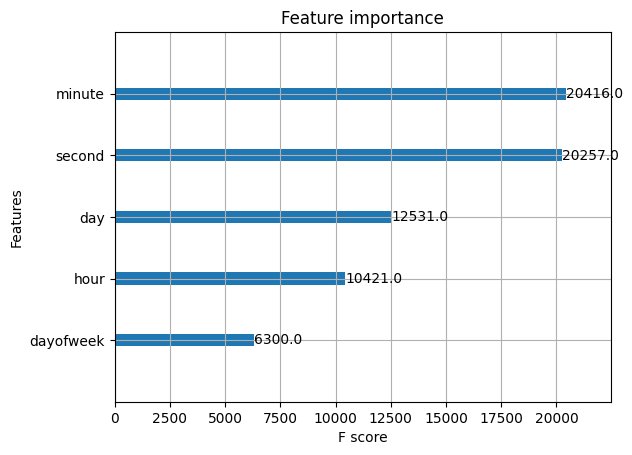

In [22]:
xgboost.plot_importance(xgb_model)

In [23]:
predictions = xgb_model.predict(X_test)
predictions

array([ -4.8649335 ,  20.019142  ,  40.26004   ,   7.069437  ,
        -6.127085  ,  34.87522   ,  -1.6586993 ,   2.575326  ,
        18.912346  ,   9.238129  ,  19.611822  ,  -5.6481056 ,
       105.207275  ,  19.176533  ,  -0.975231  ,  39.35165   ,
         3.0213606 ,  12.280953  ,  57.201416  ,  70.01273   ,
        -3.349131  ,  -9.172567  ,   0.62560445,   5.641371  ,
         1.5497581 ,   3.8302126 ,  13.749043  ,  -7.250858  ,
        17.646013  ,  -6.728126  ,  15.766588  ,  -0.66476357,
        41.398907  ,  34.417324  ,  43.863377  ,  46.67305   ,
        19.766403  ,  42.317257  ,  30.662786  ,   8.183191  ,
         9.284116  , -11.36084   ,  -3.9291177 ,  10.993368  ,
         1.1111243 ,  20.476753  ,   7.7024918 ,  24.193804  ,
        -2.9008417 ,   5.42672   ,   4.1263156 ,  11.555355  ,
        16.754135  ,  -2.3715992 ,  38.416748  ,  32.725765  ,
        -2.4912393 ,  24.681866  , -18.400034  ,   8.433589  ,
        -1.3168108 ,  11.200157  ,  -7.760588  ,   1.25

In [24]:
r_sq = xgb_model.score(X_train, y_train)
# 1에 가까울수록 좋음.
print('성능 평가 점수: {}'.format(r_sq))
print('분산 회귀 점수: {}'.format(explained_variance_score(predictions,y_test)))

성능 평가 점수: 0.7666848179377028
분산 회귀 점수: -1.6632808648012603


In [26]:
X_pred = cafe_20_gender_data
pred = xgb_model.predict(X_pred)
test = cafe_20_gender_data[:].copy()
test['target'] = cafe_20_gender_target['male']
test['pred'] = pred
test.head()

,year,month,day,dayofweek,hour,minute,second,target,pred
date,,,,,,,,,
2023-08-02 14:40:24.265000+00:00,2023,8,2,2,14,40,24,0.0,24.838318
2023-08-02 14:41:24.680000+00:00,2023,8,2,2,14,41,24,50.0,15.487538
2023-08-02 14:42:25.622000+00:00,2023,8,2,2,14,42,25,0.0,0.036938
2023-08-02 14:43:25.765000+00:00,2023,8,2,2,14,43,25,0.0,9.946507
2023-08-02 14:44:26.528000+00:00,2023,8,2,2,14,44,26,20.0,19.611822


<Axes: xlabel='date'>

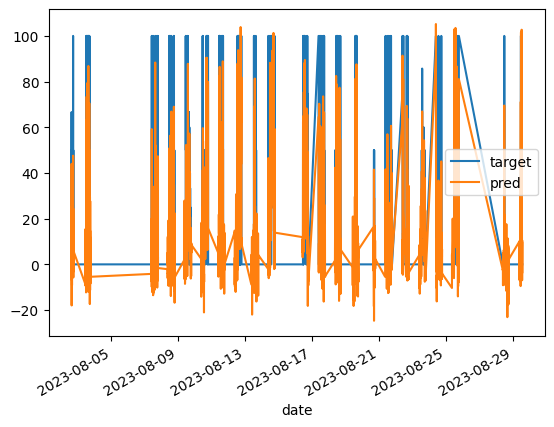

In [27]:
result = test[:]
# result = result.set_index('dayofweek')
result = result.loc[:, ['target', 'pred']]
result.plot()

23년 9월 1일 금요일(6) 17시 00분 00초 때 남성 비율 예측

In [28]:
X_test_pred = pd.DataFrame([[23, 9, 1, 6, 17, 00, 00]], columns = ['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second'])
test_pred = xgb_model.predict(X_test_pred)
test_pred

array([94.83787], dtype=float32)

1 ~ 7   
일 ~ 토   
23년 9월 1일 금요일(6) 시간대별 예측 시각화   
데이터군이 적어 모델 학습에 column 중 minute의 영향이 생각보다 너무 높다.

<Axes: >

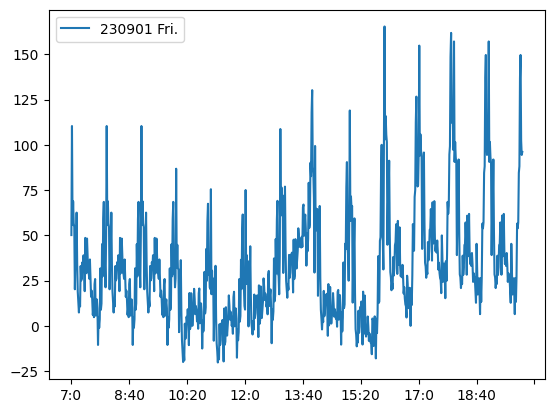

In [29]:
day_format = ['etc', 'Sun.', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.']
predict_day = [23, 9, 1, 6]
opening_hours = [7, 20]
X_test_pred = pd.DataFrame([[*predict_day, time, minute, 00] for time in range(*opening_hours) for minute in range(60)], columns = ['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second'])
test_pred = xgb_model.predict(X_test_pred)
test_result = pd.DataFrame(test_pred, index=['{}:{}'.format(hour, minute) for hour in range(*opening_hours) for minute in range(60)], columns=['{:0>2}{:0>2}{:0>2} {}'.format(*predict_day[:3], day_format[predict_day[3]])])
test_result.plot()

시간에 따른 예측 결과 시각화

<Axes: >

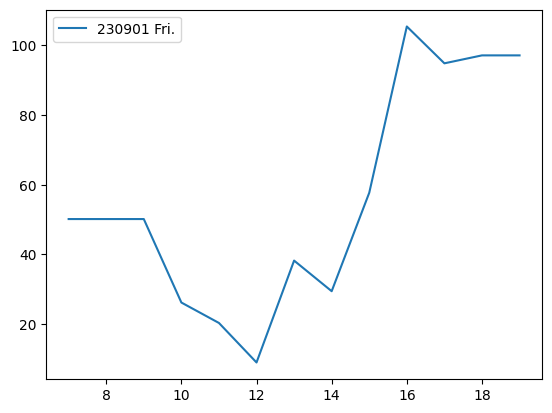

In [31]:
day_format = ['etc', 'Sun.', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.']
predict_day = [23, 9, 1, 6]
opening_hours = [7, 20]
X_test_pred = pd.DataFrame([[*predict_day, time, 00, 00] for time in range(*opening_hours)], columns = ['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second'])
test_pred = xgb_model.predict(X_test_pred)
test_result = pd.DataFrame(test_pred, index=range(*opening_hours), columns=['{:0>2}{:0>2}{:0>2} {}'.format(*predict_day[:3], day_format[predict_day[3]])])
test_result.plot()

23년 9월 3일 일요일(1) 시간대별 예측 시각화   

<Axes: >

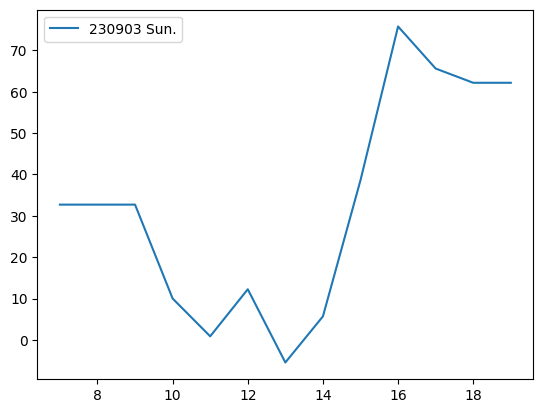

In [32]:
day_format = ['etc', 'Sun.', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.']
predict_day = [23, 9, 3, 1]
opening_hours = [7, 20]
X_test_pred = pd.DataFrame([[*predict_day, time, 00, 00] for time in range(*opening_hours)], columns = ['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second'])
test_pred = xgb_model.predict(X_test_pred)
test_result = pd.DataFrame(test_pred, index=range(*opening_hours), columns=['{:0>2}{:0>2}{:0>2} {}'.format(*predict_day[:3], day_format[predict_day[3]])])
test_result.plot()

In [40]:
import pandas as pd

import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

def result_img(cafe_id, gender):
    url = './data/freetips.level0.csv'

    df_ori = pd.read_csv(url)
    df = df_ori[:].copy()

    gender_data = df[:].copy()
    gender_data['date'] = pd.to_datetime(gender_data['timestamp'])
    gender_data = gender_data.set_index('date')
    gender_data['year'] = gender_data.index.year
    gender_data['month'] = gender_data.index.month
    gender_data['day'] = gender_data.index.day
    gender_data['dayofweek'] = gender_data.index.dayofweek
    gender_data['hour'] = gender_data.index.hour
    gender_data['minute'] = gender_data.index.minute
    gender_data['second'] = gender_data.index.second
    gender_data['time'] = gender_data.index.time
    gender_data['date'] = gender_data.index.date
    gender_data['day'] = gender_data.index.day
    male_data = []
    female_data = []
    for data in gender_data['gender']:
        male_data.append(ast.literal_eval(data)['male'])
        female_data.append(ast.literal_eval(data)['female'])
    gender_data['male'] = male_data
    gender_data['female'] = female_data

    cafe = gender_data[gender_data['cafe_id'] == cafe_id][['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second', 'male', 'female']]
    cafe_gender_data = cafe[['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second']]
    cafe_gender_target = cafe[[gender]]

    X_train, X_test, y_train, y_test = train_test_split(cafe_gender_data, cafe_gender_target ,test_size=0.1)
    xgb_model = xgboost.XGBRegressor(n_estimators=10000, learning_rate=0.04, gamma=0, subsample=0.75,
                            colsample_bytree=1, max_depth=3)

    print(len(X_train), len(X_test))
    xgb_model.fit(X_train,y_train)

    X_pred = cafe_gender_data
    pred = xgb_model.predict(X_pred)
    test = cafe_gender_data[:].copy()
    test['target'] = cafe_gender_target[gender]
    test['pred'] = pred

    result = test[:]
    # result = result.set_index('dayofweek')
    result = result.loc[:, ['target', 'pred']]
    result.plot(title='cafe_id: {}, {}'.format(cafe_id, gender))

    X_test_pred = pd.DataFrame([[23, 9, 1, 6, 18, 00, 00]], columns = ['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second'])
    test_pred = xgb_model.predict(X_test_pred)

    day_format = ['etc', 'Sun.', 'Mon.', 'Tue.', 'Wed.', 'Thu.', 'Fri.', 'Sat.']
    predict_day = [23, 9, 1, 6]
    opening_hours = [7, 20]
    X_test_pred = pd.DataFrame([[*predict_day, time, 00, 00] for time in range(*opening_hours)], columns = ['year', 'month', 'day', 'dayofweek', 'hour', 'minute', 'second'])
    test_pred = xgb_model.predict(X_test_pred)
    test_result = pd.DataFrame(test_pred, index=range(*opening_hours), columns=['cafe_id: {}, {}, {:0>2}{:0>2}{:0>2} {}'.format(cafe_id, gender, *predict_day[:3], day_format[predict_day[3]])])
    test_result.plot()

In [41]:
cafe_ids = df.cafe_id.unique()
cafe_ids

array([20, 18, 17, 16, 21,  6,  3,  2, 23, 13,  5])

male---cafe_id: 20---
3015 336
male---cafe_id: 18---
1694 189
male---cafe_id: 17---
2416 269
male---cafe_id: 16---
3199 356
male---cafe_id: 21---
2346 261
male---cafe_id: 6---
1624 181
male---cafe_id: 3---
1324 148
male---cafe_id: 2---
934 104
male---cafe_id: 23---
78 9
male---cafe_id: 13---
556 62
male---cafe_id: 5---
183 21


/Users/maze-ryeol_7/opt/anaconda3/envs/seat_occupancy/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


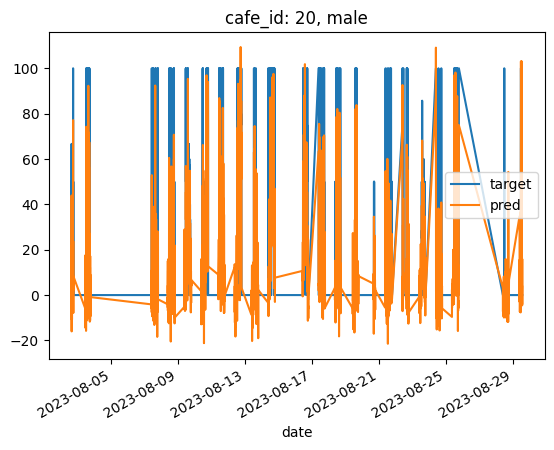

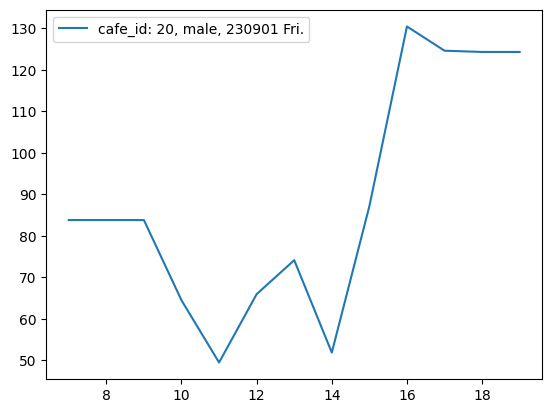

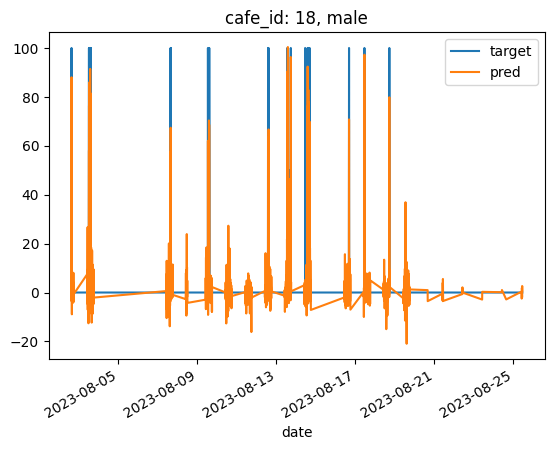

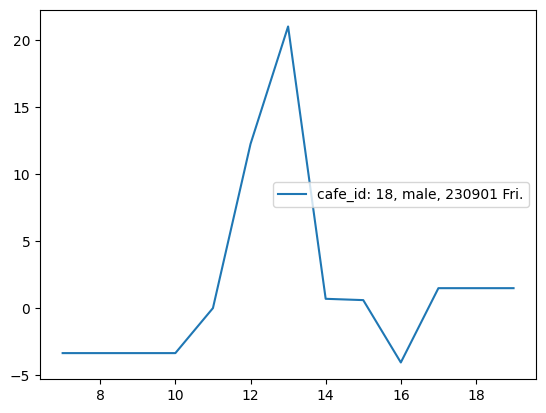

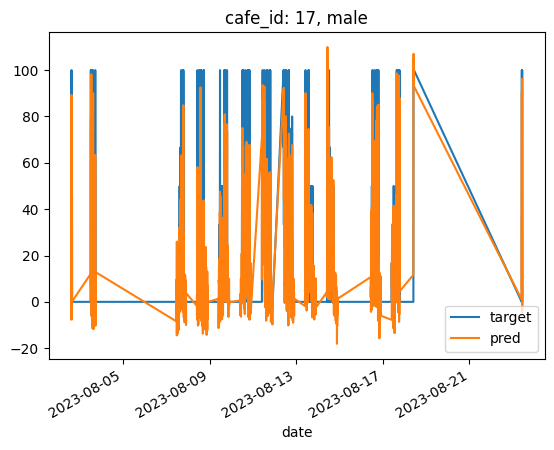

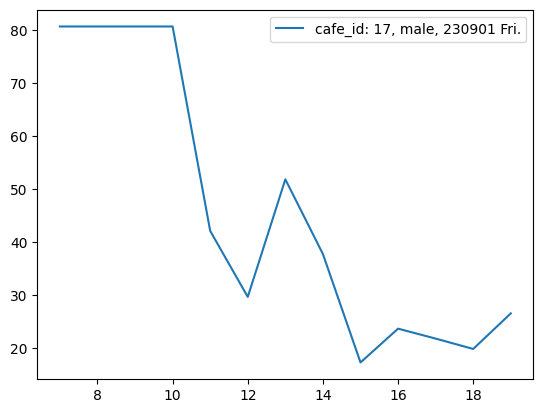

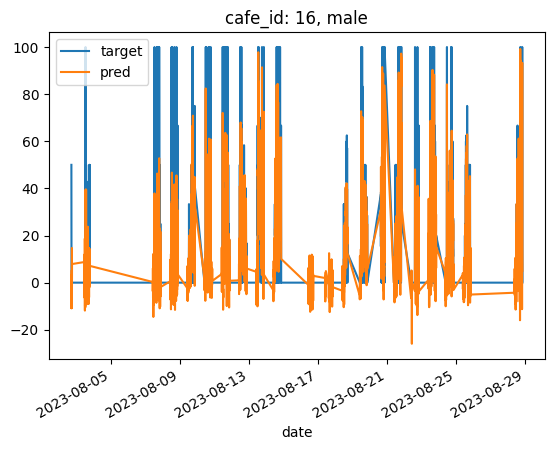

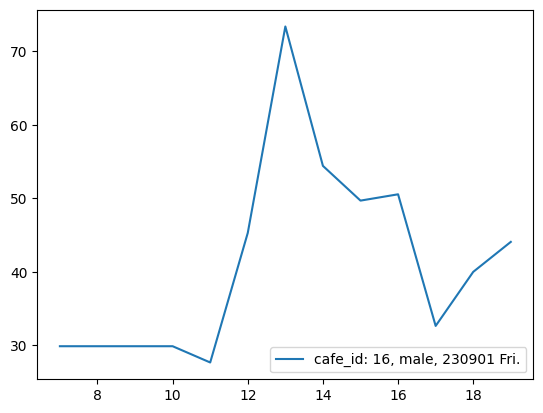

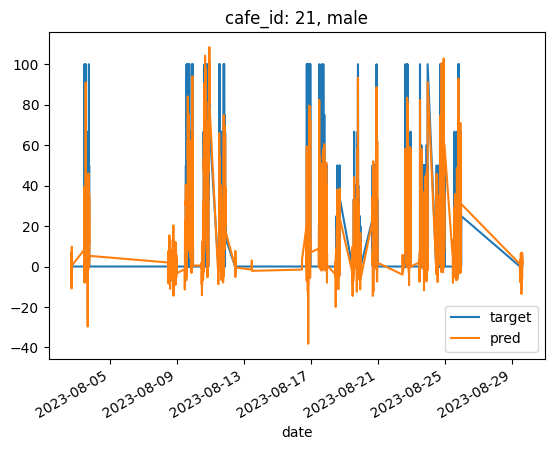

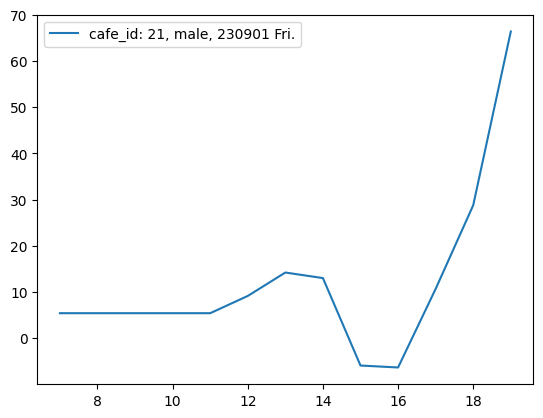

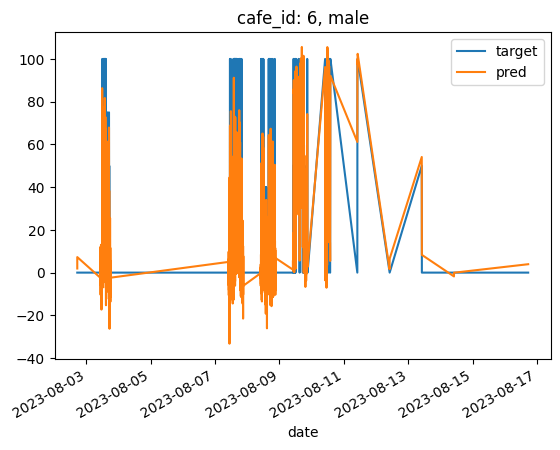

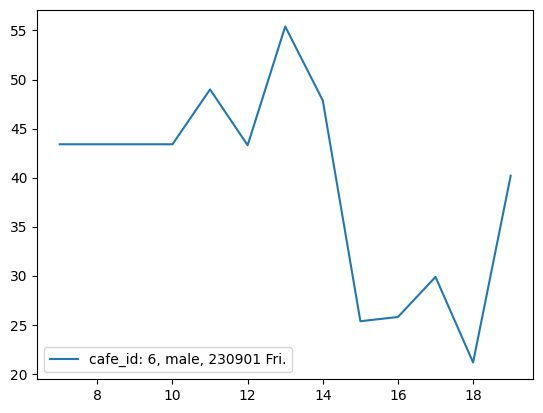

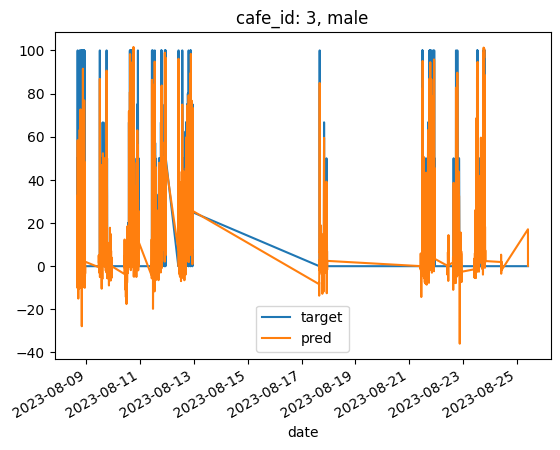

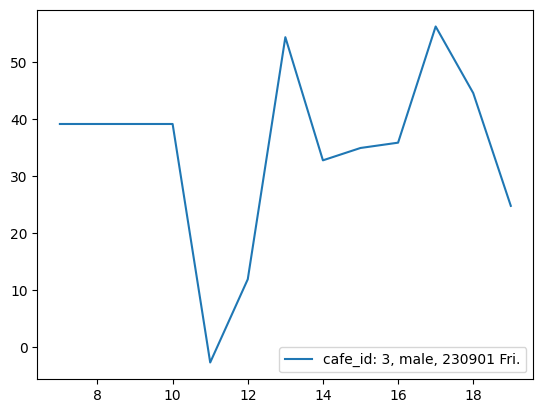

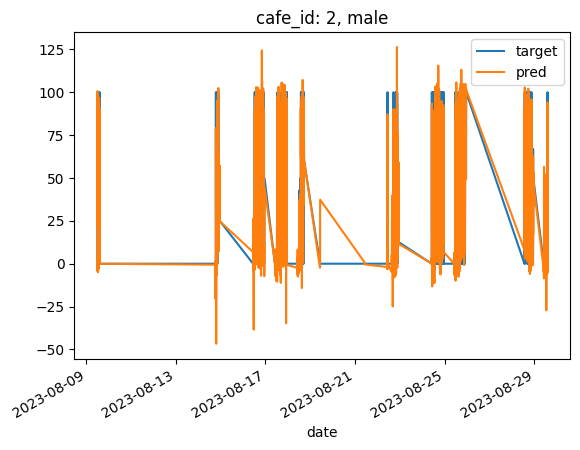

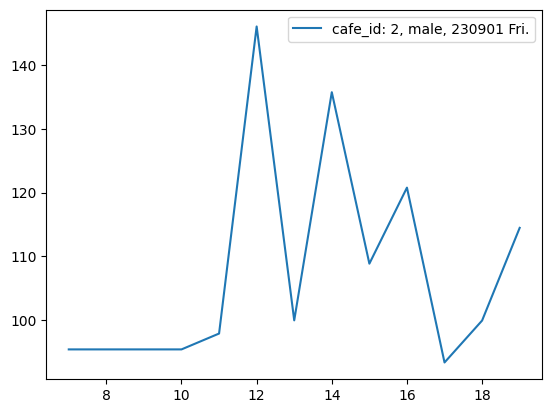

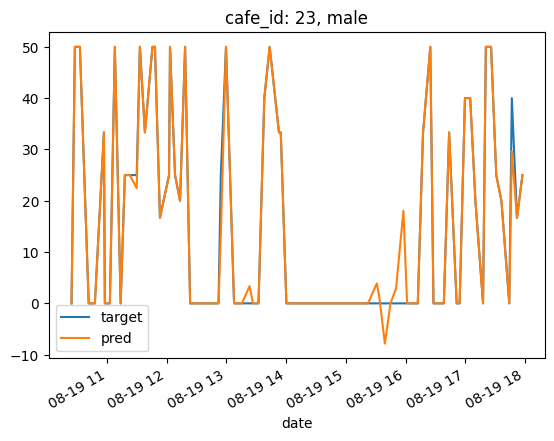

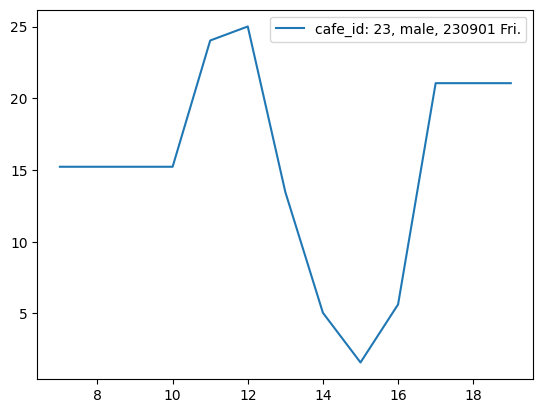

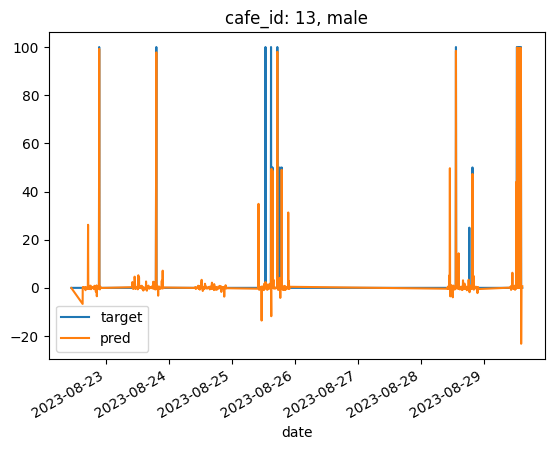

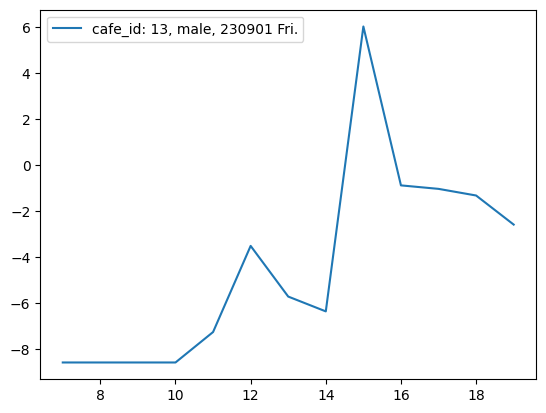

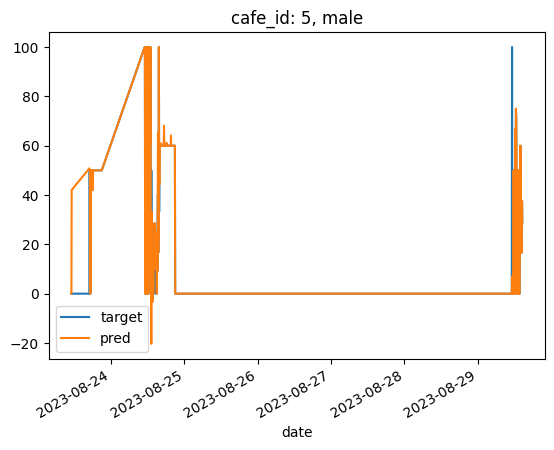

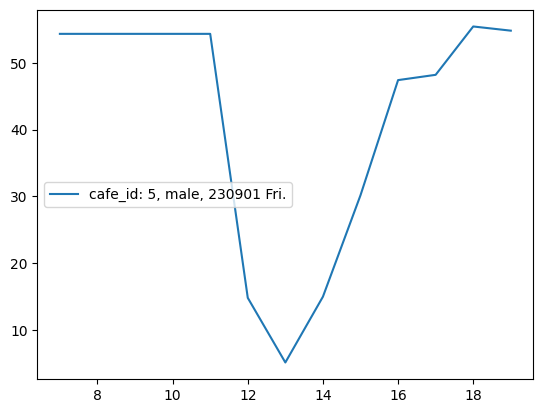

In [42]:
gender = 'male'
for cafe_id in cafe_ids:
    print('{}---cafe_id: {}---'.format(gender, cafe_id))
    result_img(cafe_id, gender)

female---cafe_id: 20---
3015 336
female---cafe_id: 18---
1694 189
female---cafe_id: 17---
2416 269
female---cafe_id: 16---
3199 356
female---cafe_id: 21---
2346 261
female---cafe_id: 6---
1624 181
female---cafe_id: 3---
1324 148
female---cafe_id: 2---
934 104
female---cafe_id: 23---
78 9
female---cafe_id: 13---
556 62
female---cafe_id: 5---
183 21


/Users/maze-ryeol_7/opt/anaconda3/envs/seat_occupancy/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


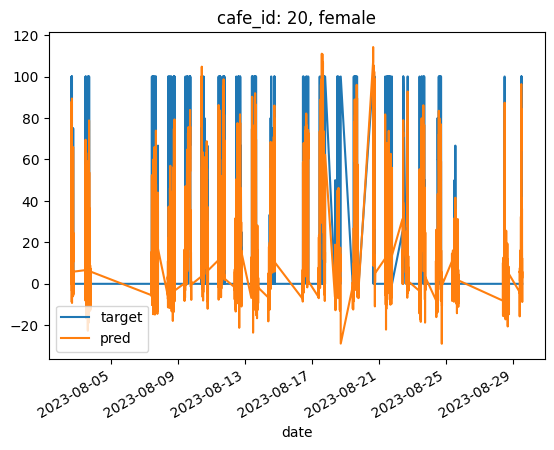

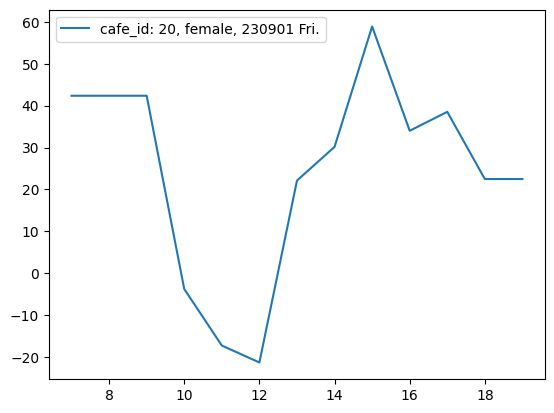

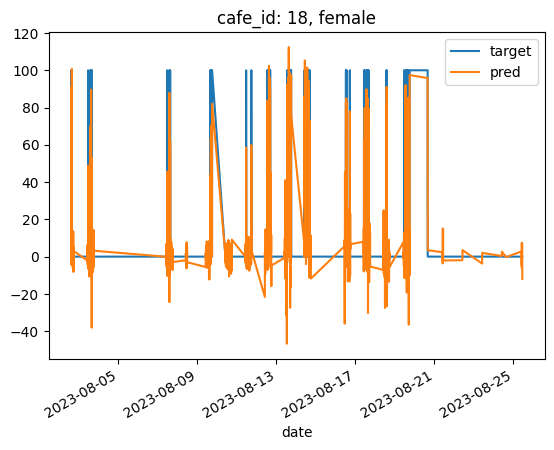

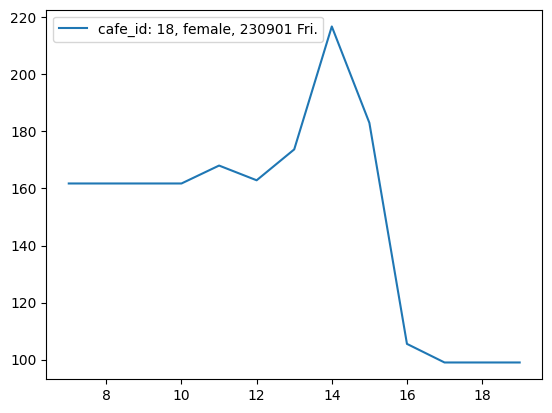

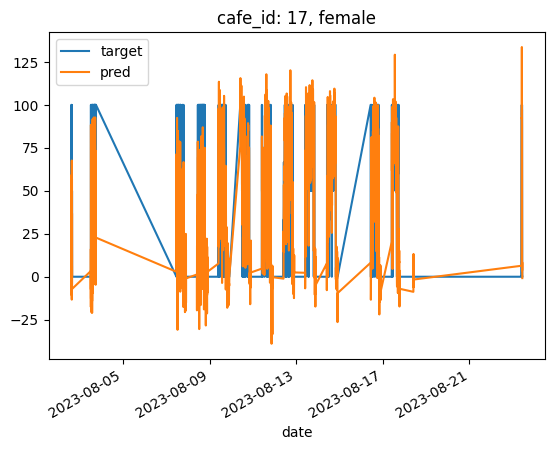

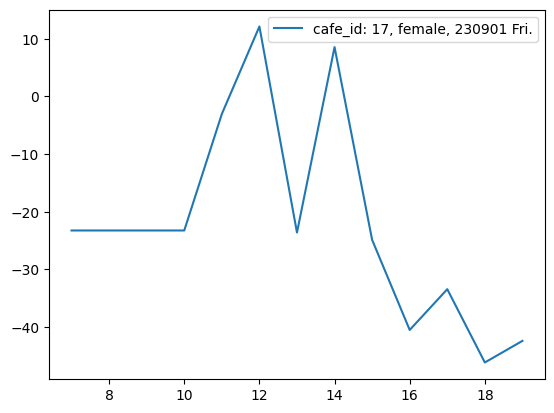

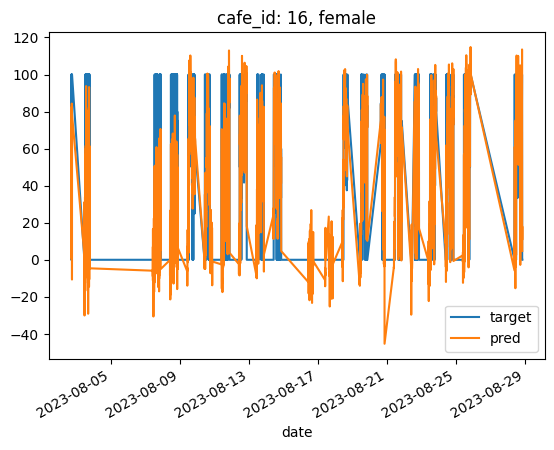

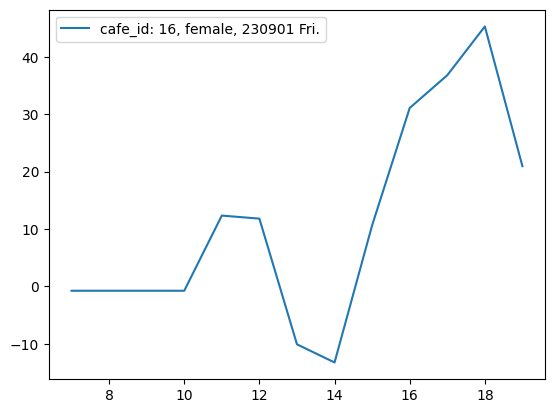

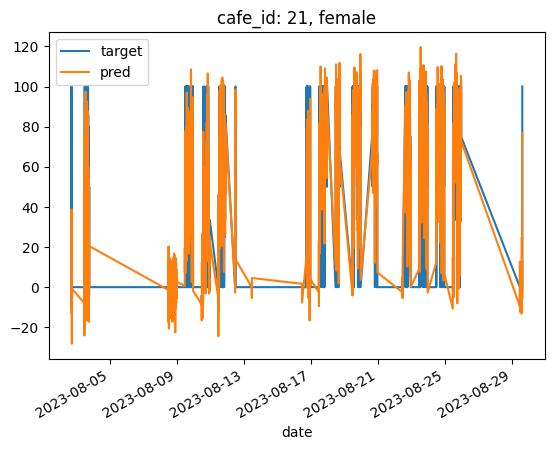

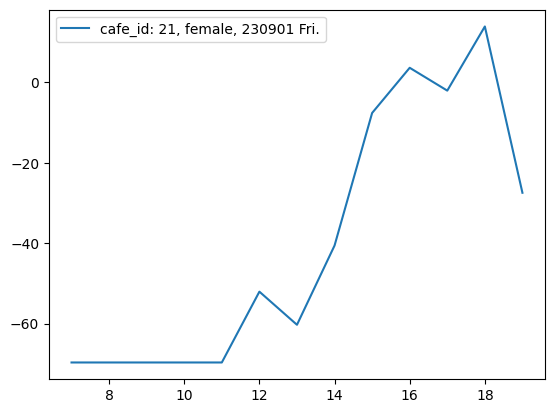

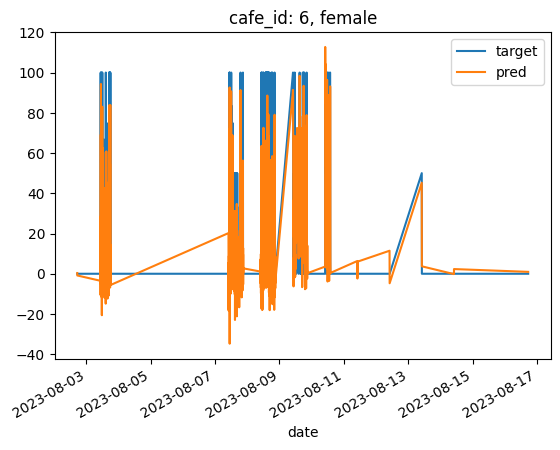

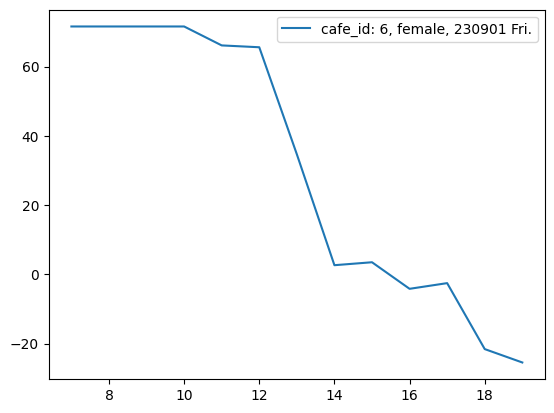

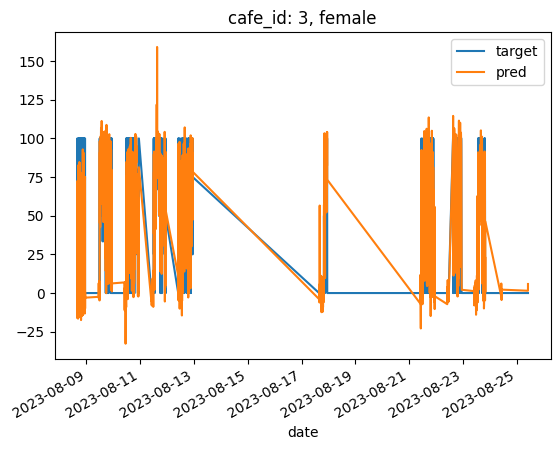

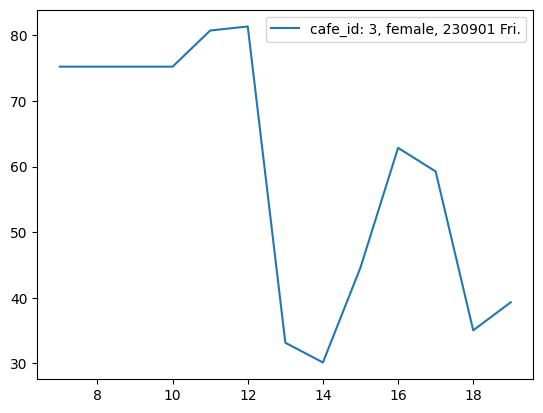

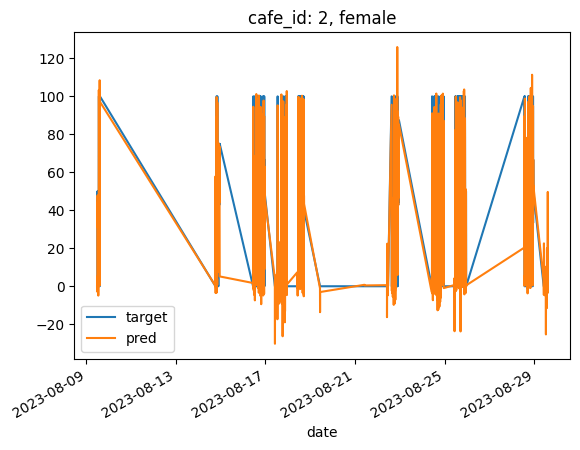

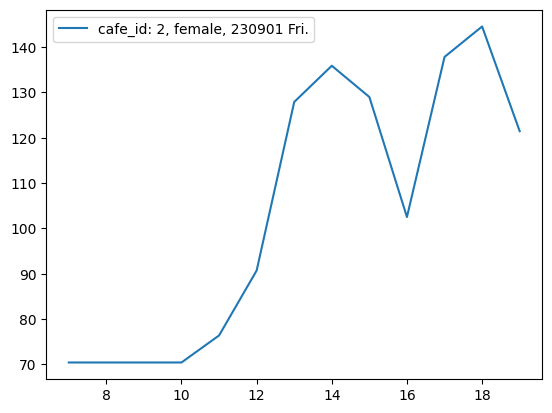

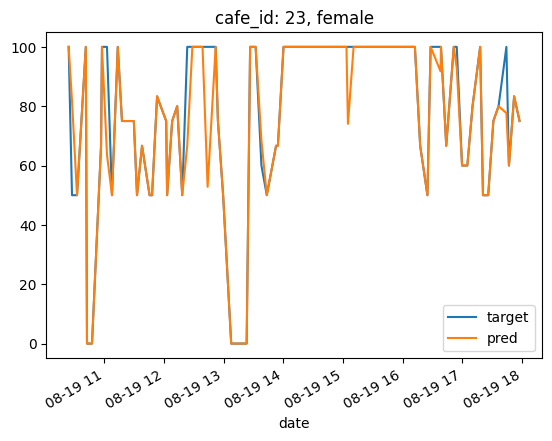

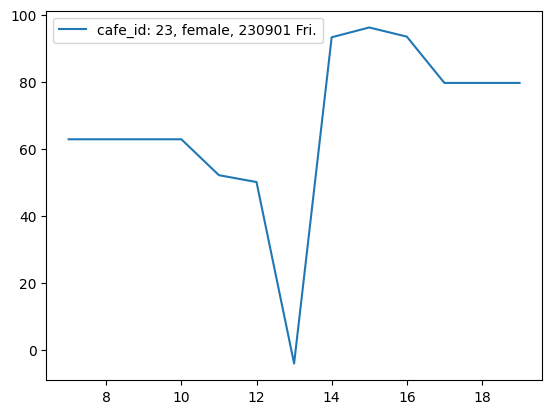

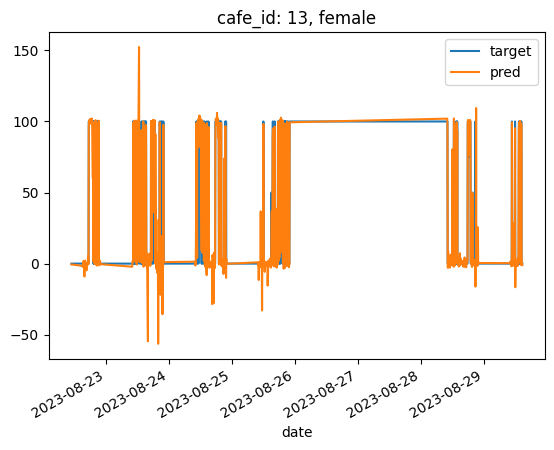

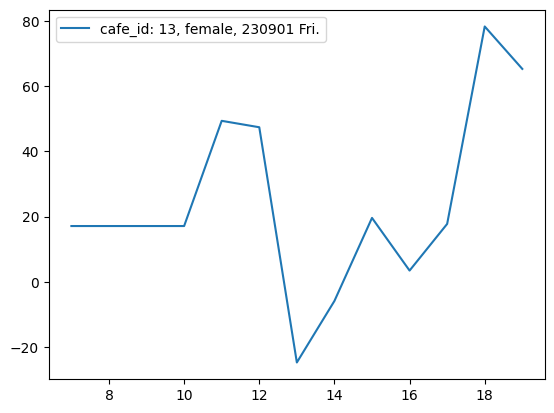

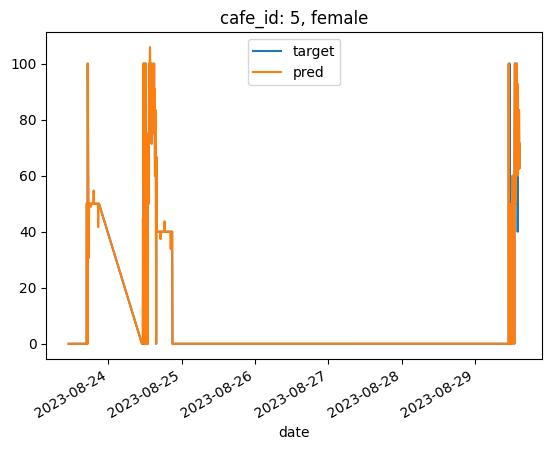

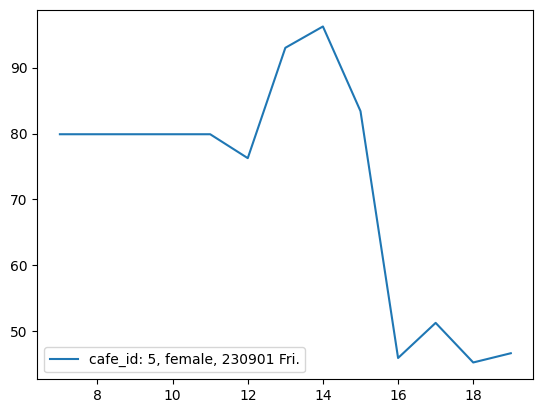

In [43]:
gender = 'female'
for cafe_id in cafe_ids:
    print('{}---cafe_id: {}---'.format(gender, cafe_id))
    result_img(cafe_id, gender)